# MNIST Digits Classification using Neural Networks



In this part we will implement our first Neural Network!
We will use fully connecter Neural Network in order to classify handwritten digits. We will use the well known MNIST dataset. The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Imports

In [ ]:
#importing modules that will be in use
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split



Mount your drive in order to run locally with colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/MTA/Deep Learning/Assignment 2/FC
from utils import *

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MTA/Deep Learning/Assignment 2/FC


**QUESTION 1**: What are the problems with sigmoid?

**ANSWER**: First, for the most part the gradients of the sigmoid are almost 0, which makes the learning process almost impossible. Then, its output is allways positive which makes the weight update process longer due to the zig-zag problem. At last, the exponent computation of the sigmoid is relatively expensive.

here we will implement the sigmoid activation function and it's gradient. You should not use any build-in function of sigmoid.

In [ ]:

def sigmoid(x):
    # impement the sigmoid funciton
    # ====== YOUR CODE: ======
    sig = 1 / (1 + torch.exp(-x))
    # ========================
    return sig



def softmax(x):
    """
  Softmax loss function, should be implemented in a vectorized fashion (without loops)


  Inputs:
  - X: A torch array of shape (N, C) containing a minibatch of data.
  Returns:
  - probabilities: A torch array of shape (N, C) containing the softmax probabilities.

     """
    #for stability (do not change)
    max_per_row, inds = torch.max(x, dim=1)
    x = (x.T - max_per_row).T
    
    # ====== YOUR CODE: ======
    probabilities = torch.exp(x ** 2) / torch.sum(torch.exp(x ** 2), 
                                                  dim=1, 
                                                  keepdim=True)
    # ========================
    return probabilities

Implement a fully-vectorized loss function for the Softmax classifier.


In [ ]:
def cross_entropy_error(y, t):
    """
    Inputs:

    - t:  A torch array of shape (N,C) containing  a minibatch of training label. it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: A torch array of shape (N, C) containing the softmax probabilities (the NN's output).

    Returns:
    - loss as single float (do not forget to divide by the number of samples in the minibatch (N))
    """
    # ====== YOUR CODE: ======   
    # Compute loss 
    error = -1 * torch.sum(t * torch.log(y)) / y.size(0)
    # ========================
    return error

In [ ]:
def get_accuracy(y,t):
    """
    Computes the accuracy of the NN's predictions.
    Inputs:
    - t:  A torch array of shape (N,C) containing training labels, it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: the torch probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    Returns:
    - accuracy: a single float of the average accuracy.
    """
    # ====== YOUR CODE: ======  
    accuracy = sum(torch.argmax(y, dim=1) == torch.argmax(t, dim=1)) / y.size(0)
    accuracy = accuracy.item()
    # ========================    
    return accuracy



## Fully-connected Network

We will design and train a two-layer fully-connected neural network with sigmoid nonlinearity and
softmax cross entropy loss. We assume an input dimension of D=784, a hidden dimension of H, and perform classification over C classes.

The architecture should be fullyconnected -> sigmoid -> fullyconnected -> softmax.

We will use torch.nn for the linear functions



### config

In [ ]:
args={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=15  #The number of Epochs
args['validation_ratio']=0.15 #The validation ratio from training set  
args['eval_every']=1 #Will evaluate the model ever <eval_every> epochs

## load the data

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
device

'cuda'

In [ ]:
def create_train_validation_loaders(dataset: Dataset, 
                                         validation_ratio,
                                         batch_size=100):
    """
    Splits a dataset into a train and validation set, returning a
    DataLoader for each.
    :param dataset: The original dataset.
    :param validation_ratio: Ratio (in range 0,1) of the validation set size to
        total dataset size.
    :param batch_size: Batch size the loaders will return from each set.
    :return: A tuple of train, validation and test DataLoader instances.
    """
    if not(0.0 < validation_ratio < 1.0):
        raise ValueError(validation_ratio)
        
        
    # TODO: Create two DataLoader instances, dataloader_train and dataloader_valid.
    # They should together represent a train/validation split of the given
    # dataset. Make sure that:
    # 1. Validation set size is validation_ratio * total number of samples.
    # 2. No sample is in both datasets. You can select samples at random
    #    from the dataset.
    # 3. you use shuffle=True in the train dataloader and shuffle=False in the validation dataloder
    

    # ====== YOUR CODE: ======
    ds_train, ds_valid = train_test_split(dataset, test_size=validation_ratio, random_state=42)
    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    dl_valid = DataLoader(ds_valid, batch_size=batch_size, shuffle=False)
    # ========================

    return dl_train, dl_valid

In [ ]:
#load the data
dataset = datasets.MNIST('./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Normalize((0.1307,), (0.3081,))])
                        )

train_loader, val_loader = create_train_validation_loaders(dataset, 
                                                           validation_ratio = args['validation_ratio'],
                                                           batch_size= args['batch_size'])

In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [ ]:
dataloaders = {'training':train_loader,
               'val':val_loader,
               'test':test_loader
              }

## Fully connected Neural Network

In [ ]:
class FullyConnectedNeuralNetwork(nn.Module):
    #This defines the structure of the NN.
    def __init__(self,
                 hidden_layer_dim
                 ):
      super(FullyConnectedNeuralNetwork, self).__init__()
      # Define the model layers. 
      # Use the torch.nn.Linear layers. Set the hidden layer dim to hidden_layer_dim. 
      # Notice that the input dim is 784 and the output dim is 10 (number of classes).
      # ====== YOUR CODE: ======
      self.fc1 = torch.nn.Linear(784, hidden_layer_dim)
      self.fc2 = torch.nn.Linear(hidden_layer_dim, 10)
      # ========================

    def forward(self, x):
      x = torch.flatten(x, start_dim=1, end_dim=-1)
      # ====== YOUR CODE: ======
      x = self.fc1(x)
      x = sigmoid(x)
      x = self.fc2(x)
      y = softmax(x)  
      # ========================
      return y

The following functions will train our model

In [ ]:
def forward_one_epoch(loader,
                      optimizer,
                      net,
                      mode,
                      progress_bar_str,
                      num_of_epochs
                     ):
    

    losses, cur_accuracies = [], []
    all_preds,all_targets = [], []
    for batch_idx, (inputs, targets) in enumerate(loader):
        
        if mode == Mode.training:
            optimizer.zero_grad()
            
        inputs, targets =inputs.to(device), targets.to(device)
        outputs = net(inputs)
        targets = F.one_hot(targets, num_classes=10)
        loss = cross_entropy_error(outputs, targets)
        losses.append(loss.item())

        if mode == Mode.training:
            #do a step 
            loss.backward()
            optimizer.step()
            
        if len(targets.shape) ==2:
            cur_accuracies.append(get_accuracy(outputs, targets))
            
        if batch_idx %20 ==0:
            progress_bar(batch_idx, len(loader), progress_bar_str
                   % (num_of_epochs, np.mean(losses), losses[-1], np.mean(cur_accuracies)))
            
        targets_cpu = targets.cpu().data.numpy()
        outputs_cpu = [i.cpu().data.numpy() for i in outputs]
        outputs_cpu = np.argmax(outputs_cpu, axis=1)

        all_targets.extend(targets_cpu)
        all_preds.extend(outputs_cpu)

        del inputs, targets, outputs
        torch.cuda.empty_cache()


    return losses, cur_accuracies, all_targets, all_preds




In [ ]:
def train(args, dataloaders):
  seed = 0
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

  model = FullyConnectedNeuralNetwork(hidden_layer_dim = args['hidden_layer_dim'])
  model = model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), args['lr'])

  training_accuracies, val_accuracies = [], []
  training_losses, val_losses = [], [] 


  training_loader = dataloaders['training']
  val_loader = dataloaders['val']
  test_loader = dataloaders['test']

  best_acc = -1

  #start training
  for epoch in range(1, args['epochs']+1):

      #training
      model = model.train()

      progress_bar_str = 'Train: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Train Acc: %.3f%%' 

      losses, cur_training_accuracies, _,_ =  forward_one_epoch(
          loader = training_loader,
          optimizer = optimizer,
          net = model,
          mode = Mode.training,
          progress_bar_str = progress_bar_str,
          num_of_epochs = epoch)


      train_epoch_acc = np.mean(cur_training_accuracies)
      train_epoch_loss= np.mean(losses)
      sys.stdout.flush()
      print()
      print(f'Train epoch {epoch}: accuracy {train_epoch_acc}, loss {train_epoch_loss}', flush=True)
      training_accuracies.append(train_epoch_acc)
      training_losses.append(train_epoch_loss)



      # validation
      model.eval()
      if (epoch-1)%args['eval_every']==0:
          progress_bar_str = 'Validation: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | val Acc: %.3f%%'

          losses, cur_val_accuracies,_,_ =  forward_one_epoch(val_loader,
                                                                optimizer,
                                                                model,
                                                                Mode.validation,
                                                                progress_bar_str,
                                                                epoch
                                                              )
          val_epoch_acc= np.mean(cur_val_accuracies)
          val_epoch_loss= np.mean(losses)
          sys.stdout.flush()
          val_accuracies.append(val_epoch_acc)

          val_epoch_acc = np.round(val_epoch_acc,3)
          print()
          print(f'Validation epoch {epoch//args["eval_every"]}: accuracy {val_epoch_acc}, loss {val_epoch_loss}', flush=True)
          val_losses.append(val_epoch_loss)
          
          cur_acc_loss = {
            'training_accuracies':training_accuracies,
            'val_accuracies':val_accuracies,
            'training_losses':training_losses,
            'val_losses':val_losses
                        }

          if best_acc +0.001 < val_epoch_acc:

              best_acc = val_epoch_acc
              best_acc_epoch = epoch

              print(f'========== new best model! epoch {best_acc_epoch}, accuracy {best_acc}  ==========')
              best_model = copy.deepcopy(model)

              
  progress_bar_str = 'Test: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Acc: %.3f%%'
  test_losses, test_cur_test_accuracies, test_all_targets, test_all_preds = forward_one_epoch(test_loader,
                                                                None,
                                                                best_model,
                                                                Mode.test,
                                                                progress_bar_str,
                                                                0)

  test_epoch_acc= np.mean(test_cur_test_accuracies)
  test_epoch_loss= np.mean(test_losses)
  print("===================== Test Results =====================")
  print(f'Test Accuracy : {test_epoch_acc}')
  print(f'Test Loss : {test_epoch_loss}')
  return best_model, cur_acc_loss 

## Training Process

We will finetune two hyper parameters:
1. The hidden layer dimension.
2. The learning rate.

### Finetuning hidden_layer_dim 

#### hidden_layer_dim = 1, lr = 0.0001  

Set the hidden_layer_dim to 1 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 1
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.09925490676188002, loss 3.543679821724985

Validation epoch 1: accuracy 0.1, loss 3.1557718647850885
========== new best model! epoch 1, accuracy 0.1  ==========

Train epoch 2: accuracy 0.09925490676188002, loss 2.983805642408483

Validation epoch 2: accuracy 0.1, loss 2.8895517190297446

Train epoch 3: accuracy 0.09927451420648425, loss 2.8160071092493393

Validation epoch 3: accuracy 0.1, loss 2.7844710614946155

Train epoch 4: accuracy 0.09933333800119512, loss 2.7394307828417013

Validation epoch 4: accuracy 0.1, loss 2.7279306517706976

Train epoch 5: accuracy 0.099725495512579, loss 2.694782107484107

Validation epoch 5: accuracy 0.101, loss 2.691949394014147

Train epoch 6: accuracy 0.1011960833680396, loss 2.664932648340861

Validation epoch 6: accuracy 0.101, loss 2.6665657626258

Train epoch 7: accuracy 0.10270588757360682, loss 2.643167921141082

Validation epoch 7: accuracy 0.103, loss 2.647371212641398
========== new best model! epoch 7, accurac

Best val accuracy was 0.11877778338061439, at epoch 14


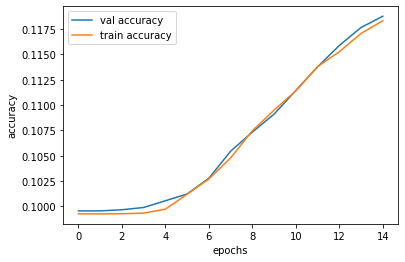

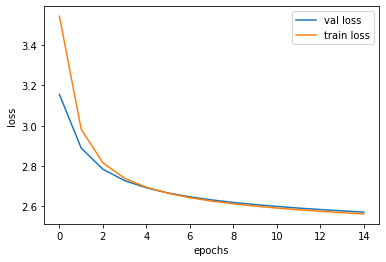

0.11877778338061439

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: Accuracy = about 12%, Loss = about 2.556. The accuracy increases slowly, as well as the loss but it does not seem like it will decrease a lot below 2.6 so the model might not learn much better then it did.

#### hidden_layer_dim = 5, lr = 0.0001

Set the hidden_layer_dim to 5 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 5
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.0974509850436566, loss 2.5391775860505947

Validation epoch 1: accuracy 0.097, loss 2.5254501236809626
========== new best model! epoch 1, accuracy 0.097  ==========

Train epoch 2: accuracy 0.0974509850436566, loss 2.5201559627757355

Validation epoch 2: accuracy 0.097, loss 2.507731384701199

Train epoch 3: accuracy 0.09745098445929733, loss 2.5032479763031006

Validation epoch 3: accuracy 0.097, loss 2.4919524987538657

Train epoch 4: accuracy 0.09745098460538715, loss 2.4881685995588114

Validation epoch 4: accuracy 0.097, loss 2.4778530597686768

Train epoch 5: accuracy 0.09745098445929733, loss 2.474666296267042

Validation epoch 5: accuracy 0.097, loss 2.4652080270979138

Train epoch 6: accuracy 0.0974509850436566, loss 2.4625312721028045

Validation epoch 6: accuracy 0.097, loss 2.4538288646274142

Train epoch 7: accuracy 0.09745098489756678, loss 2.4515925575705135

Validation epoch 7: accuracy 0.097, loss 2.4435505072275796

Train epoch 8: accuracy 

Best val accuracy was 0.0968888940082656, at epoch 0


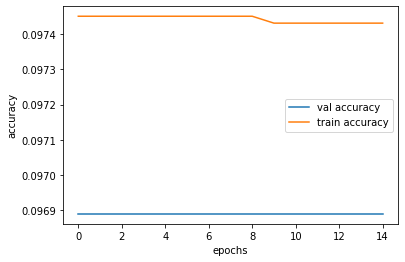

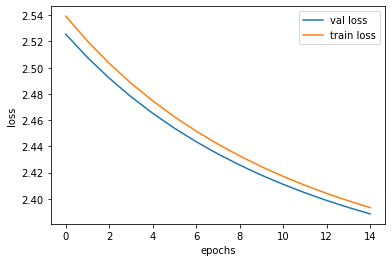

0.0968888940082656

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: Accuracy = about 10%, Loss = about 2.525. The accuracy stays pretty constant, the loss seems to decrease slowly. It seems like it might take a lot of epochs for the model to learn significantly better then it did so far.

#### hidden_layer_dim = 100, lr = 0.0001

Set the hidden_layer_dim to 100 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.03798039367093759, loss 2.3458984973383883

Validation epoch 1: accuracy 0.036, loss 2.342591789033678
========== new best model! epoch 1, accuracy 0.036  ==========

Train epoch 2: accuracy 0.038137256368702535, loss 2.339386449140661

Validation epoch 2: accuracy 0.036, loss 2.336862564086914

Train epoch 3: accuracy 0.038274511439250966, loss 2.3342314374213124

Validation epoch 3: accuracy 0.036, loss 2.3322614563835993

Train epoch 4: accuracy 0.03852941329572715, loss 2.3300429933211384

Validation epoch 4: accuracy 0.037, loss 2.3284488783942328

Train epoch 5: accuracy 0.03903921708172443, loss 2.32653621598786

Validation epoch 5: accuracy 0.037, loss 2.325218094719781

Train epoch 6: accuracy 0.039313727076731475, loss 2.3235326280780866

Validation epoch 6: accuracy 0.037, loss 2.3224376837412515

Train epoch 7: accuracy 0.03972549195967469, loss 2.320915699005127

Validation epoch 7: accuracy 0.038, loss 2.319995297325982
========== new best model

Best val accuracy was 0.04388889090882407, at epoch 14


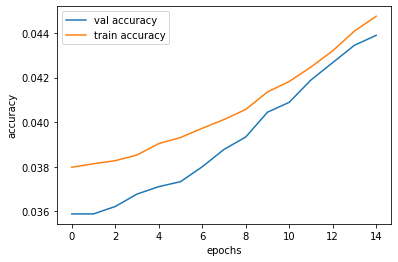

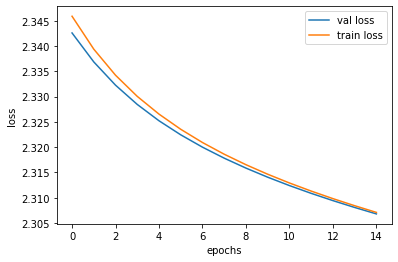

0.04388889090882407

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: Accuracy = about 5%, Loss = about 2.3. The accuracy increases pretty slowly, the loss seems to decrease slowly as well. It seems like it might take a lot of epochs for the model to learn significantly better then it did so far.

#### hidden_layer_dim = 200, lr = 0.0001

Set the hidden_layer_dim to 200 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 200
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.088823533452609, loss 2.3173435342078115

Validation epoch 1: accuracy 0.089, loss 2.3152162763807507
========== new best model! epoch 1, accuracy 0.089  ==========

Train epoch 2: accuracy 0.09162745537126765, loss 2.3150911658417943

Validation epoch 2: accuracy 0.092, loss 2.3132624096340604
========== new best model! epoch 2, accuracy 0.092  ==========

Train epoch 3: accuracy 0.09374510248502095, loss 2.3132849721347584

Validation epoch 3: accuracy 0.094, loss 2.31163928243849
========== new best model! epoch 3, accuracy 0.094  ==========

Train epoch 4: accuracy 0.09607843557993571, loss 2.311748831879859

Validation epoch 4: accuracy 0.096, loss 2.3102302816179066
========== new best model! epoch 4, accuracy 0.096  ==========

Train epoch 5: accuracy 0.098666671444388, loss 2.3103950257394827

Validation epoch 5: accuracy 0.099, loss 2.308972888522678
========== new best model! epoch 5, accuracy 0.099  ==========

Train epoch 6: accuracy 0.10115686760

Best val accuracy was 0.12166667150126563, at epoch 14


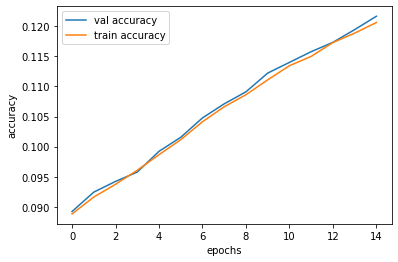

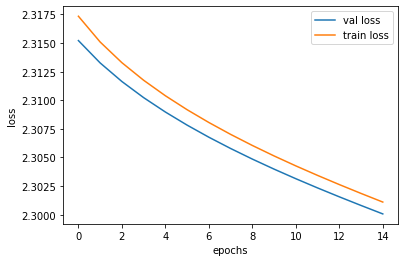

0.12166667150126563

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.4**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: Accuracy = about 12%, Loss = about 2.3. The accuracy increases pretty slowly, the loss seems to decrease slowly as well. It seems like it might take a lot of epochs for the model to learn significantly better then it did so far.

### Finetuning learning rate

#### hidden_layer_dim = 100, lr = 0.000001

Set the hidden_layer_dim to 100 and the lr to 0.000001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.000001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.03790196232205512, loss 2.349609604068831

Validation epoch 1: accuracy 0.036, loss 2.3498267332712808
========== new best model! epoch 1, accuracy 0.036  ==========

Train epoch 2: accuracy 0.03790196232205512, loss 2.349526737250534

Validation epoch 2: accuracy 0.036, loss 2.349743949042426

Train epoch 3: accuracy 0.03790196261423476, loss 2.3494440621020747

Validation epoch 3: accuracy 0.036, loss 2.3496611648135715

Train epoch 4: accuracy 0.03790196228553267, loss 2.349361653421439

Validation epoch 4: accuracy 0.036, loss 2.3495788839128284

Train epoch 5: accuracy 0.037921570314496174, loss 2.3492795018588795

Validation epoch 5: accuracy 0.036, loss 2.349496603012085

Train epoch 6: accuracy 0.03792157009536145, loss 2.349197551315906

Validation epoch 6: accuracy 0.036, loss 2.3494147459665933

Train epoch 7: accuracy 0.03792157020492881, loss 2.349115811142267

Validation epoch 7: accuracy 0.036, loss 2.3493330743577747

Train epoch 8: accuracy 0

Best val accuracy was 0.036111112063129745, at epoch 0


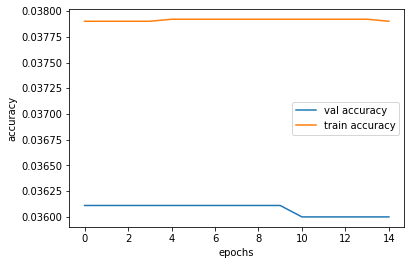

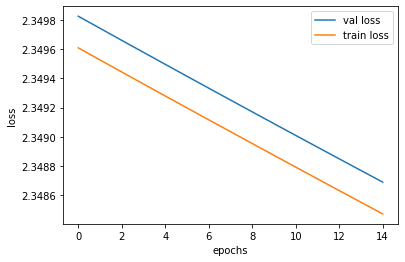

0.036111112063129745

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: Accuracy = about 4%, Loss = about 2.35. The accuracy stays pretty constant, the loss seems to decrease slowly. It looks like it might take a lot of epochs for the model to learn significantly better then it did so far.

#### hidden_layer_dim = 100, lr = 0.1

Set the hidden_layer_dim to 1 and the lr to 0.1 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']= 0.1
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.6158823829655554, loss 1.2776304500944473

Validation epoch 1: accuracy 0.85, loss 0.5029039747185178
========== new best model! epoch 1, accuracy 0.85  ==========

Train epoch 2: accuracy 0.8744706277753792, loss 0.4183085467301163

Validation epoch 2: accuracy 0.894, loss 0.3410424855020311
========== new best model! epoch 2, accuracy 0.894  ==========

Train epoch 3: accuracy 0.9002157286101696, loss 0.3376294672489166

Validation epoch 3: accuracy 0.869, loss 0.4062044554286533

Train epoch 4: accuracy 0.910627494840061, loss 0.300883445669623

Validation epoch 4: accuracy 0.916, loss 0.28443599078390336
========== new best model! epoch 4, accuracy 0.916  ==========

Train epoch 5: accuracy 0.9188823957069248, loss 0.2749173758076687

Validation epoch 5: accuracy 0.922, loss 0.267202893892924
========== new best model! epoch 5, accuracy 0.922  ==========

Train epoch 6: accuracy 0.9199216097008949, loss 0.26980900881337183

Validation epoch 6: accuracy 0.

Best val accuracy was 0.9502222604221768, at epoch 14


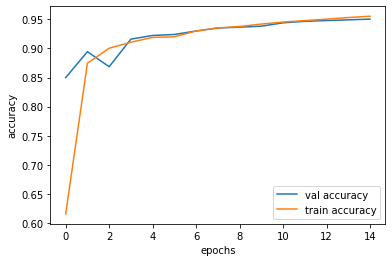

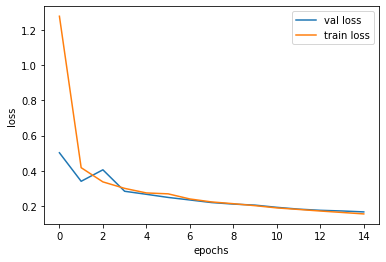

0.9502222604221768

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: Accuracy = about 95%, Loss = about 0.163. The accuracy increases quickly and then reaches a plateau, the loss seems to decrease quickly and then reaches a plateau as well. It seems like the change in the LR was very critical for the learning process of our model.

#### hidden_layer_dim = 100, lr = 0.001

Set the hidden_layer_dim to 100 and the lr to 0.001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.001  
best_model, cur_acc_loss  = train(args, dataloaders)


Train epoch 1: accuracy 0.0391568644885339, loss 2.3272880152160047

Validation epoch 1: accuracy 0.04, loss 2.3139922089046903
========== new best model! epoch 1, accuracy 0.04  ==========

Train epoch 2: accuracy 0.04517647222268815, loss 2.3067919273002473

Validation epoch 2: accuracy 0.049, loss 2.301110029220581
========== new best model! epoch 2, accuracy 0.049  ==========

Train epoch 3: accuracy 0.058196081104231814, loss 2.295821839687871

Validation epoch 3: accuracy 0.068, loss 2.291280402077569
========== new best model! epoch 3, accuracy 0.068  ==========

Train epoch 4: accuracy 0.08962745540866665, loss 2.2856959081163595

Validation epoch 4: accuracy 0.116, loss 2.280695332421197
========== new best model! epoch 4, accuracy 0.116  ==========

Train epoch 5: accuracy 0.1537647124599008, loss 2.273765386319628

Validation epoch 5: accuracy 0.187, loss 2.2674044503106012
========== new best model! epoch 5, accuracy 0.187  ==========

Train epoch 6: accuracy 0.21135295080

Best val accuracy was 0.5908889108233981, at epoch 14


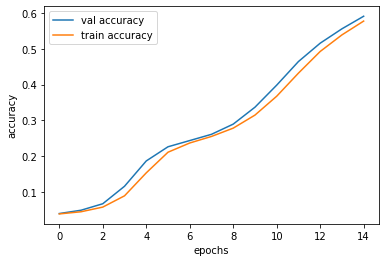

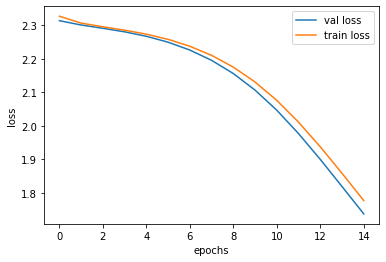

0.5908889108233981

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: Accuracy = about 61%, Loss = about 1.71. The accuracy increases quickly, the loss seems to decrease quickly. Neither seem to reach a plateau. It seems like the LR is slightly small, and our model performs better with bigger one.

**QUESTION 4:** : Suggest a way to improve the results by changing the networks's architecture  

**ANSWER**: One way to improve the results of our model is to use an additional hidden layer or more. This will help our model to learn better and more complex features within the data, and produce more accurate results on the test set.




## Explainability

Here we will plot some of the network weights.
**Be sure you run this cell with your best model!**

(784, 100)


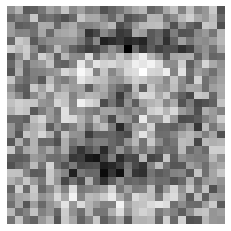

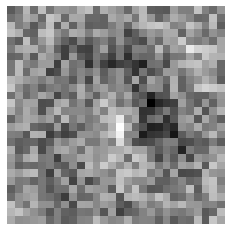

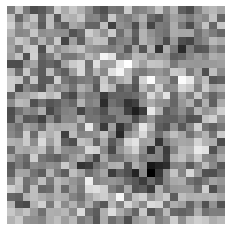

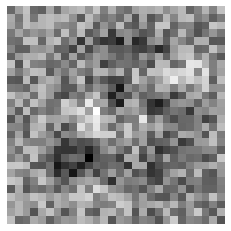

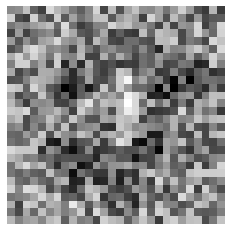

In [ ]:
# Visualize some weights. features of digits should be somehow present.
def show_net_weights(net_params):
    W1 = net_params.fc1.weight.cpu().data.numpy().T
    print(W1.shape)
    for i in range(5):
        W = W1[:,i*5].reshape(28, 28)
        plt.imshow(W,cmap='gray')
        plt.axis('off')
        plt.show()

show_net_weights(best_model)


**QUESTION 5:** Where are the bright regions? why?

**ANSWER:** The bright regions are mainly in the center of the matrices shown above. Each matrix represents a neuron in the hidden layer. Each neuron computes the dot product of the weights and the input image pixels. Thus, each matrix seems to represent a specific shape/pattern in the input image. The bright regions tell us what patterns/shapes the neurons are looking for.